## Exportation des 100 plus grosses erreurs

On veut exporter dans un tableau excel, nos 100 plus grosses erreurs afin de pouvoir analyser nos données plus simplement.

In [3]:
from bigml.api import BigML
import numpy as np
from pandas import DataFrame, read_csv, Series

prediction=read_csv('./BatchPrediction/val_predictions.csv', index_col=0)

# On ajoute une colonne "Type_Error" à notre tableau

prediction.insert(4,"Type_Error","")

On crée une fonction fctError qui nous permet de compléter la colonne "Type_Error".

In [4]:
def fctError(row):
    
    if row['SeriousDlqin2yrs'] == 1 and row['Prediction'] == 0:
        row['Type_Error'] = 'FN'
    if row['SeriousDlqin2yrs'] == 0 and row['Prediction'] == 1:
        row['Type_Error'] = 'FP'
    if row['SeriousDlqin2yrs'] == 1 and row['Prediction'] == 1:
        row['Type_Error'] = 'TP'
    if row['SeriousDlqin2yrs'] == 0 and row['Prediction'] == 0:
        row['Type_Error'] = 'TN'
    
    return row

In [5]:
prediction['Type_Error']=prediction[['Type_Error','SeriousDlqin2yrs','Prediction']].apply(fctError, axis=1)

On peut dénombrer les FN, FP, TP et TN grâce à la fonction .value_counts() pour obtenir la matrice de confusion.

In [6]:
number_error = prediction['Type_Error'].value_counts()
print(number_error)

TN    27748
FN     1613
TP      387
FP      252
Name: Type_Error, dtype: int64


On tri selon les colonnes 'Type_Error' et '0 Proba' de manière à avoir les FN en premier et avec une '0 Proba' décroissante, afin de pouvoir sélectionner et enregistrer en csv les 100 plus grosses erreurs.

In [7]:
sorted_prediction = prediction.sort_values(by = ['Type_Error', '0 Proba'], ascending = ["FN", False])

In [8]:
sorted_prediction[0:99].to_csv('top100_fn_error.csv')

On calcule notre gain total à l'aide de '.at' puisque le type(number_error) est 'pandas.core.series.Series'.   
On pondère selon *500, *0, *-2500 et *500 respectivement pour FP, TP, FN, TN, ce qui correspond aux coûts de chaque décision.

In [9]:
total_gain = number_error.at['FP']*(-500) + number_error.at['TP']*0 + number_error.at['FN']*(-2500) + number_error.at['TN']*500
print(total_gain)

9715500


## Création d'un seuil variable

Nous avons fait cela avec les 100 plus grosses erreurs de FN selon '0 Proba', maintenant nous allons vérifier avec un autre seuil.  
Tout d'abord nous allons redéfinir notre fonction pour créer un seuil que l'on va ajuster afin d'obtenir le meilleur gain, en fonction des coûts de chaque True ou False Positive/Negative que l'on nous a imposé.

In [10]:
def treshold_prediction(treshold):
    
    positive_pred = prediction['1 Proba'] >= treshold
    negative_pred = prediction['1 Proba'] < treshold
    
    positive_real = prediction['SeriousDlqin2yrs'] == 1
    negative_real = prediction['SeriousDlqin2yrs'] == 0
    
    # len pour avoir le nombre de valeurs où cette expression est vraie
    
    TP = len(prediction.loc[positive_pred & positive_real]) 
    FP = len(prediction.loc[positive_pred & negative_real])
    TN = len(prediction.loc[negative_pred & negative_real])
    FN = len(prediction.loc[negative_pred & positive_real])
    
    # Coût de chaque prédiction, en $.
    
    TP_cost = 0 
    FP_cost = -500
    TN_cost = 500
    FN_cost = -2500
    
    # matrice de coût
    
    cost = TP * TP_cost + TN * TN_cost + FP * FP_cost + FN * FN_cost
    
    return cost

On affiche notre courbe grâce à matplotlib :

Le gain maximal est de 10009500 $ et il est obtenu en 0.29


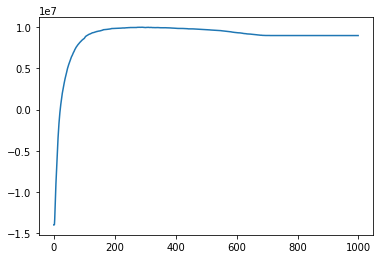

In [11]:
import matplotlib.pyplot as plt

# Ligne à mettre lors du 1er matplotlib, en cas d'erreur, pip install matplotlib dans le container handson-ml

%matplotlib inline

# On utilise un graphique pour visualiser notre gain maximum en fonction du seuil optimal

table = [treshold_prediction(i/1000) for i in range(0,1000)]

plt.plot(table)

# le maximum dans la table

max_val = max(table)
max_seuil = table.index(max_val)/1000

print(f'Le gain maximal est de {max_val} $ et il est obtenu en {max_seuil}')

## Recherche de l'AUC

On va regarder la probabilité qu'un positif sélectionné au hasard ait une probabilité de 1 "supérieure à celle d'un négatif au hasard" afin de mesurer notre AUC.

In [12]:
prediction

,SeriousDlqin2yrs,Prediction,0 Proba,1 Proba,Type_Error
field1,,,,,
99622,1,1,0.28041,0.71959,TP
86498,1,1,0.29142,0.70858,TP
97370,1,1,0.29166,0.70834,TP
105591,1,1,0.29307,0.70693,TP
146045,0,1,0.29596,0.70404,FP
...,...,...,...,...,...
6164,0,0,0.99845,0.00156,TN
29862,0,0,0.99845,0.00156,TN
50195,0,0,0.99845,0.00156,TN


In [13]:
def calc_auc():
    positive = prediction.loc[prediction['SeriousDlqin2yrs']==1]
    negative = prediction.loc[prediction['SeriousDlqin2yrs']==0]
    
    pc_sup_nc = 0  # Positive Class superior Negative Class
    combinaison = 0
    
    for threshold_p in positive['1 Proba']:
        for threshold_n in negative['1 Proba']:
            if threshold_p > threshold_n:
                pc_sup_nc += 1  # Booléen qui à chaque fois que True sort, rajoute +1
            combinaison += 1    
            auc = pc_sup_nc / combinaison
    
    return auc

In [14]:
print('On obtient un AUC de :', calc_auc())

On obtient un AUC de : 0.864702375
